In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]
Virtual memory usage - total: 126 GB / available: 75 GB / percent used: 39.8 %


# Check model data

In [2]:
var_LMDZ = 't2m'
folder_LMDZ = 'ATM'

# Define common period (remove 2 years at the beginning)
period = slice('1982','1990')

# Define zone
latlim=(10,50)
lonlim=(60,110)

var = 'tas'
label = 'Near-Surface Air Temperature'
units = '°C'
cmap='CoolWarm'
levels=plot.arange(-30,30,5)

In [3]:
path_GMTED2010 = '/data/mlalande/gpfsstore/rech/goe/ufz23bm/IGCM_OUT/LMDZOR/PROD/clim/clim-relief-GMTED2010-00625deg/'+folder_LMDZ+'/Output/MO'
model_GMTED2010 = xr.open_mfdataset(path_GMTED2010+'/*.nc', combine='by_coords')[var_LMDZ]
model_GMTED2010

<xarray.DataArray 't2m' (time_counter: 132, lat: 143, lon: 144)>
dask.array<concatenate, shape=(132, 143, 144), dtype=float32, chunksize=(12, 143, 144), chunktype=numpy.ndarray>
Coordinates:
  * lon            (lon) float32 -180.0 -177.5 -175.0 ... 172.5 175.0 177.5
  * lat            (lat) float32 90.0 88.73239 87.46479 ... -88.73239 -90.0
    time_instant   (time_counter) object dask.array<chunksize=(12,), meta=np.ndarray>
  * time_counter   (time_counter) object 1980-01-16 00:00:00 ... 1990-12-16 00:00:00
    time_centered  (time_counter) object dask.array<chunksize=(12,), meta=np.ndarray>
Attributes:
    long_name:           Temperature 2m
    units:               K
    online_operation:    average
    interval_operation:  900 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 900 s)

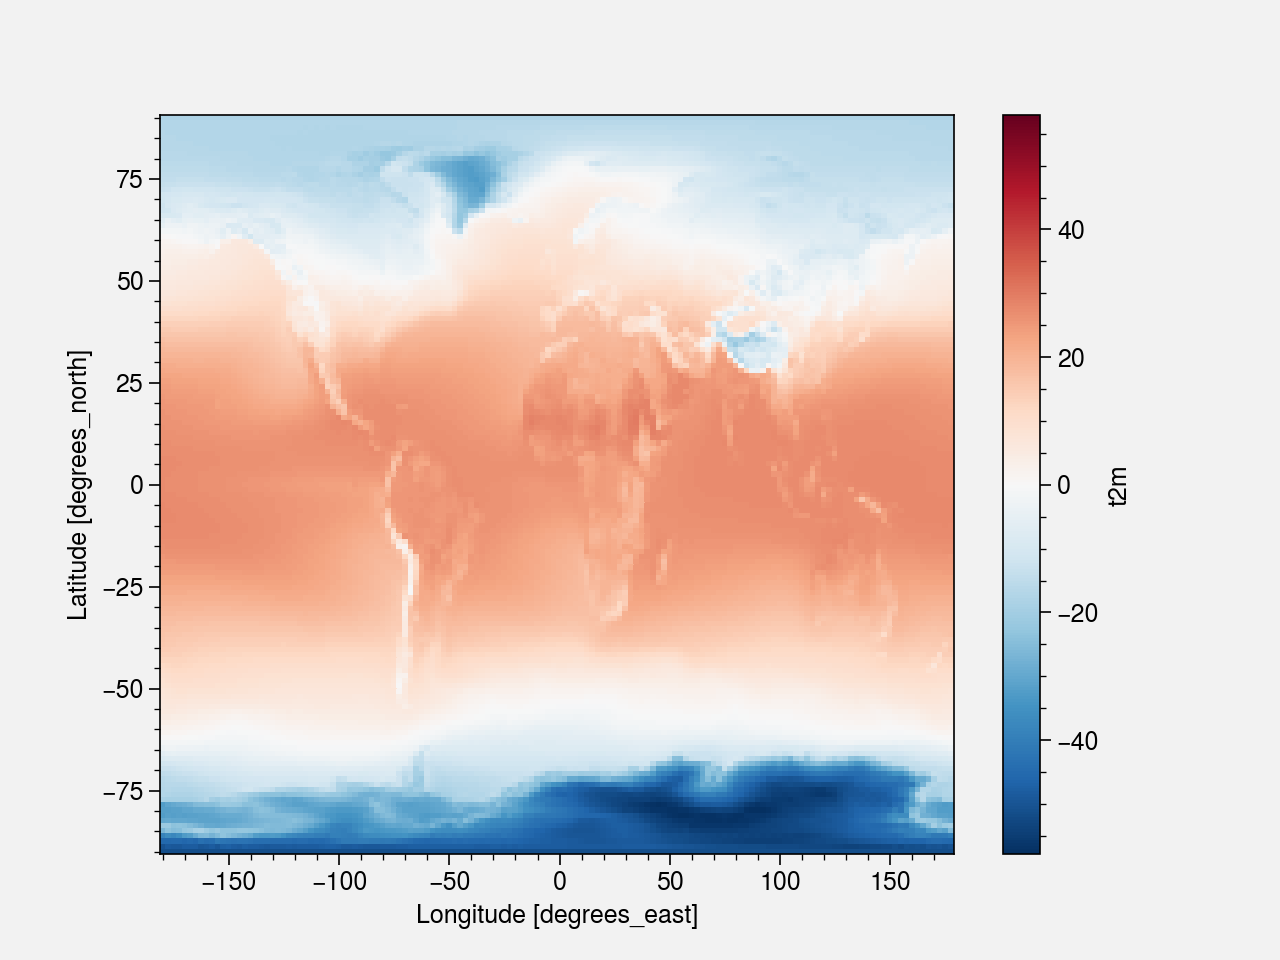

In [5]:
model_GMTED2010_clim = model_GMTED2010.sel(time_counter=period).mean('time_counter') - 273.15
model_GMTED2010_clim.plot()

In [6]:
path_def = '/data/mlalande/gpfsstore/rech/goe/ufz23bm/IGCM_OUT/LMDZOR/PROD/clim/clim-relief-def/'+folder_LMDZ+'/Output/MO'
model_def = xr.open_mfdataset(path_def+'/*.nc', combine='by_coords')[var_LMDZ]
model_def

<xarray.DataArray 't2m' (time_counter: 144, lat: 143, lon: 144)>
dask.array<concatenate, shape=(144, 143, 144), dtype=float32, chunksize=(12, 143, 144), chunktype=numpy.ndarray>
Coordinates:
  * lon            (lon) float32 -180.0 -177.5 -175.0 ... 172.5 175.0 177.5
  * lat            (lat) float32 90.0 88.73239 87.46479 ... -88.73239 -90.0
    time_instant   (time_counter) object dask.array<chunksize=(12,), meta=np.ndarray>
  * time_counter   (time_counter) object 1980-01-16 00:00:00 ... 1991-12-16 00:00:00
    time_centered  (time_counter) object dask.array<chunksize=(12,), meta=np.ndarray>
Attributes:
    long_name:           Temperature 2m
    units:               K
    online_operation:    average
    interval_operation:  900 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 900 s)

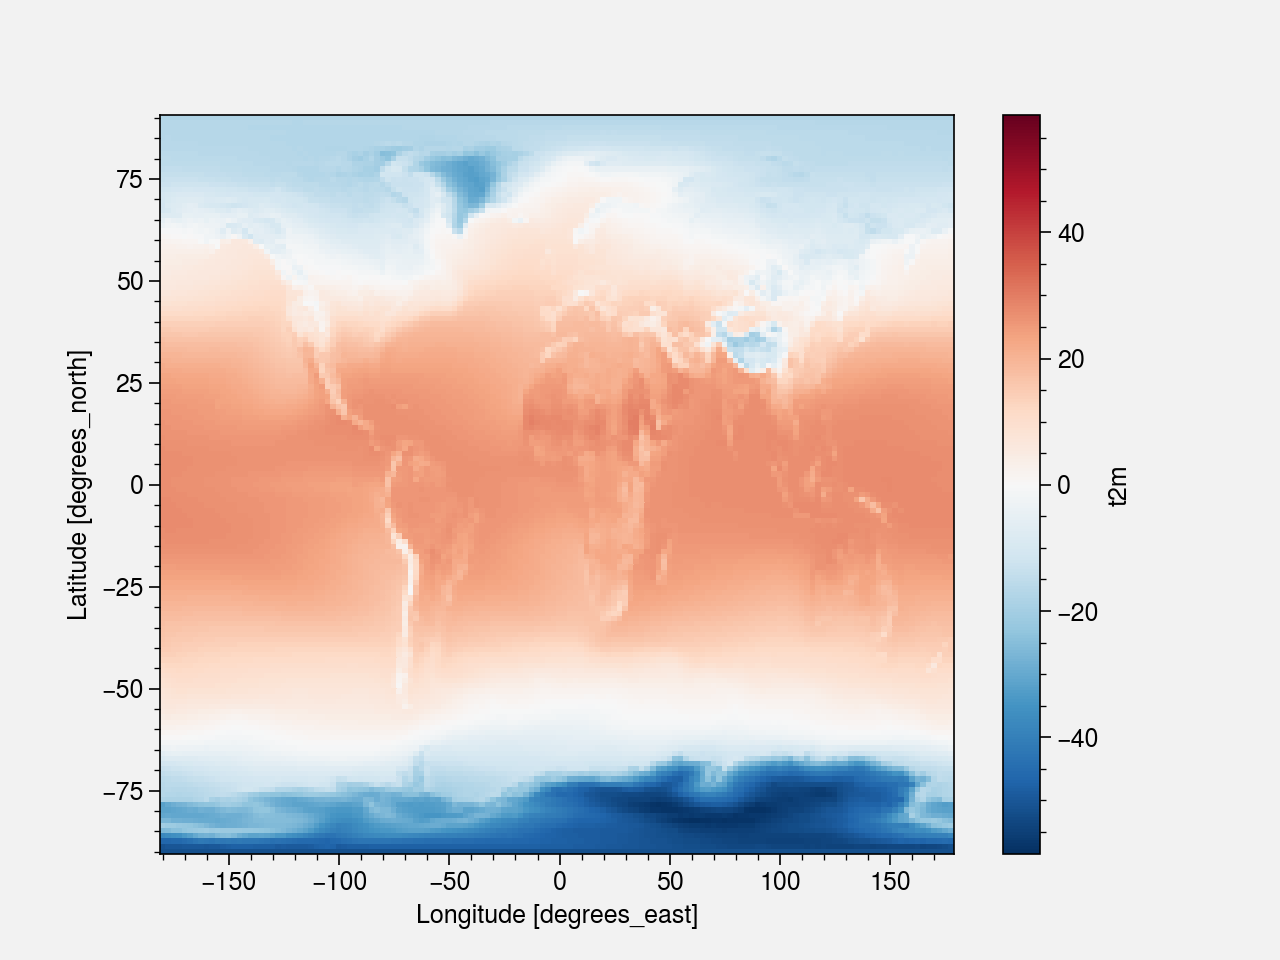

In [7]:
model_def_clim = model_def.sel(time_counter=period).mean('time_counter') - 273.15
model_def_clim.plot()

# Load obs
## cru_ts4.00
More recent version available: https://crudata.uea.ac.uk/cru/data/hrg/  
-> pas évident à télécharger encore... les netCDF ne sont pas reconnus directement, je vais rester du coup sur la version 4.00 sur CICLAD

See: http://localhost:7227/notebooks/notebooks/CICLAD/Himalaya/CMIP6_IPSL_bias/Temperature.ipynb

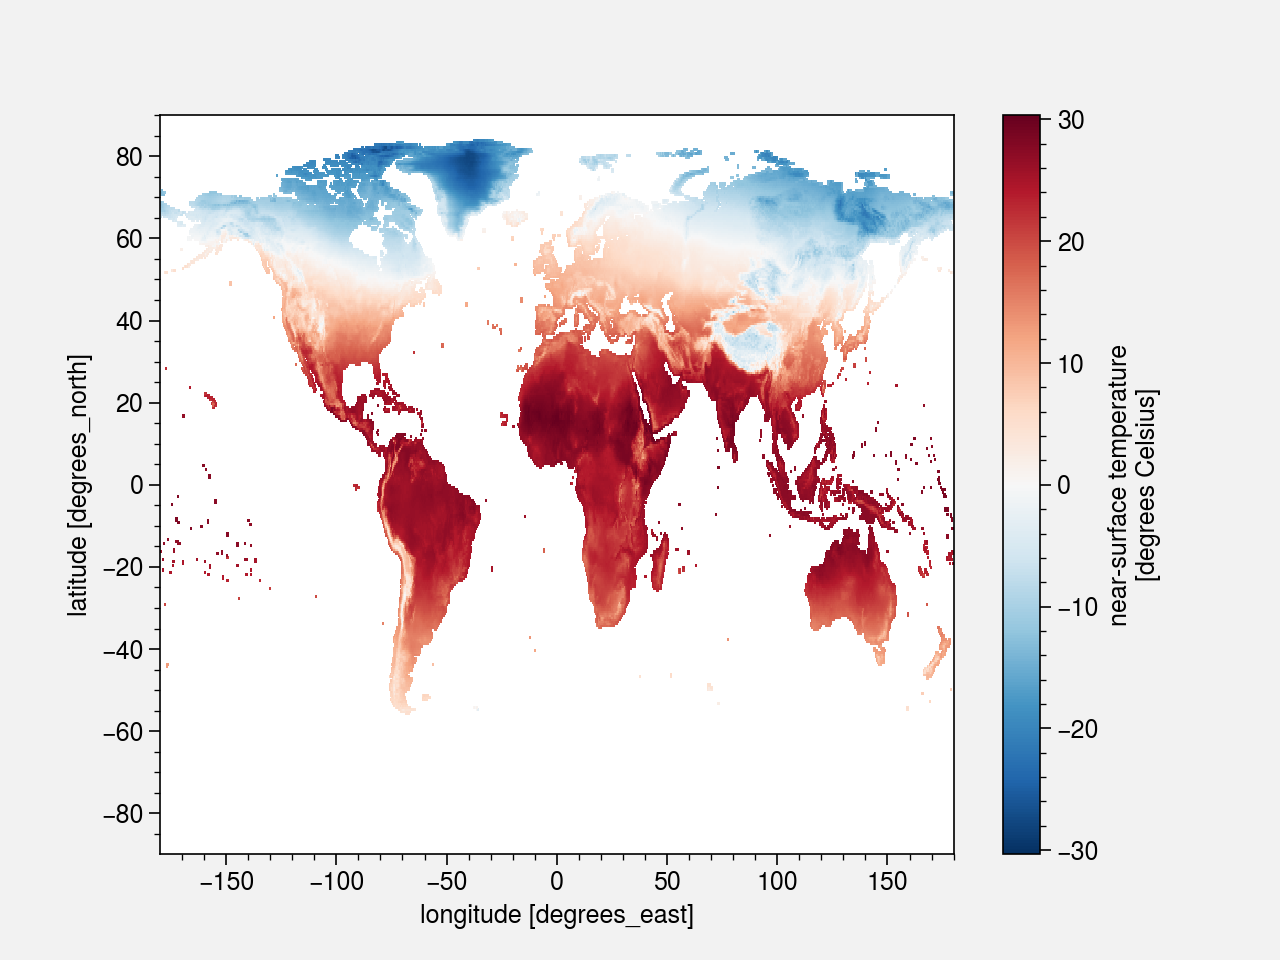

In [8]:
obs_longname = 'CRU TS v. 4.00'
obs_name = 'CRU'

obs = xr.open_dataset('/bdd/cru/cru_ts_4.00/data/tmp/cru_ts4.00.1901.2015.tmp.dat.nc').sel(time=period).tmp
obs_clim = u.clim(obs, calendar=obs.time.encoding['calendar'])
obs_clim.plot()

### Regrid using xESMF (https://xesmf.readthedocs.io/en/latest/) 

In [9]:
regridder_obs = xe.Regridder(obs_clim, model_def_clim, 'bilinear', periodic=True, reuse_weights=True)
obs_clim_regrid = regridder_obs(obs_clim)

Create weight file: bilinear_360x720_143x144_peri.nc


# Plot differences

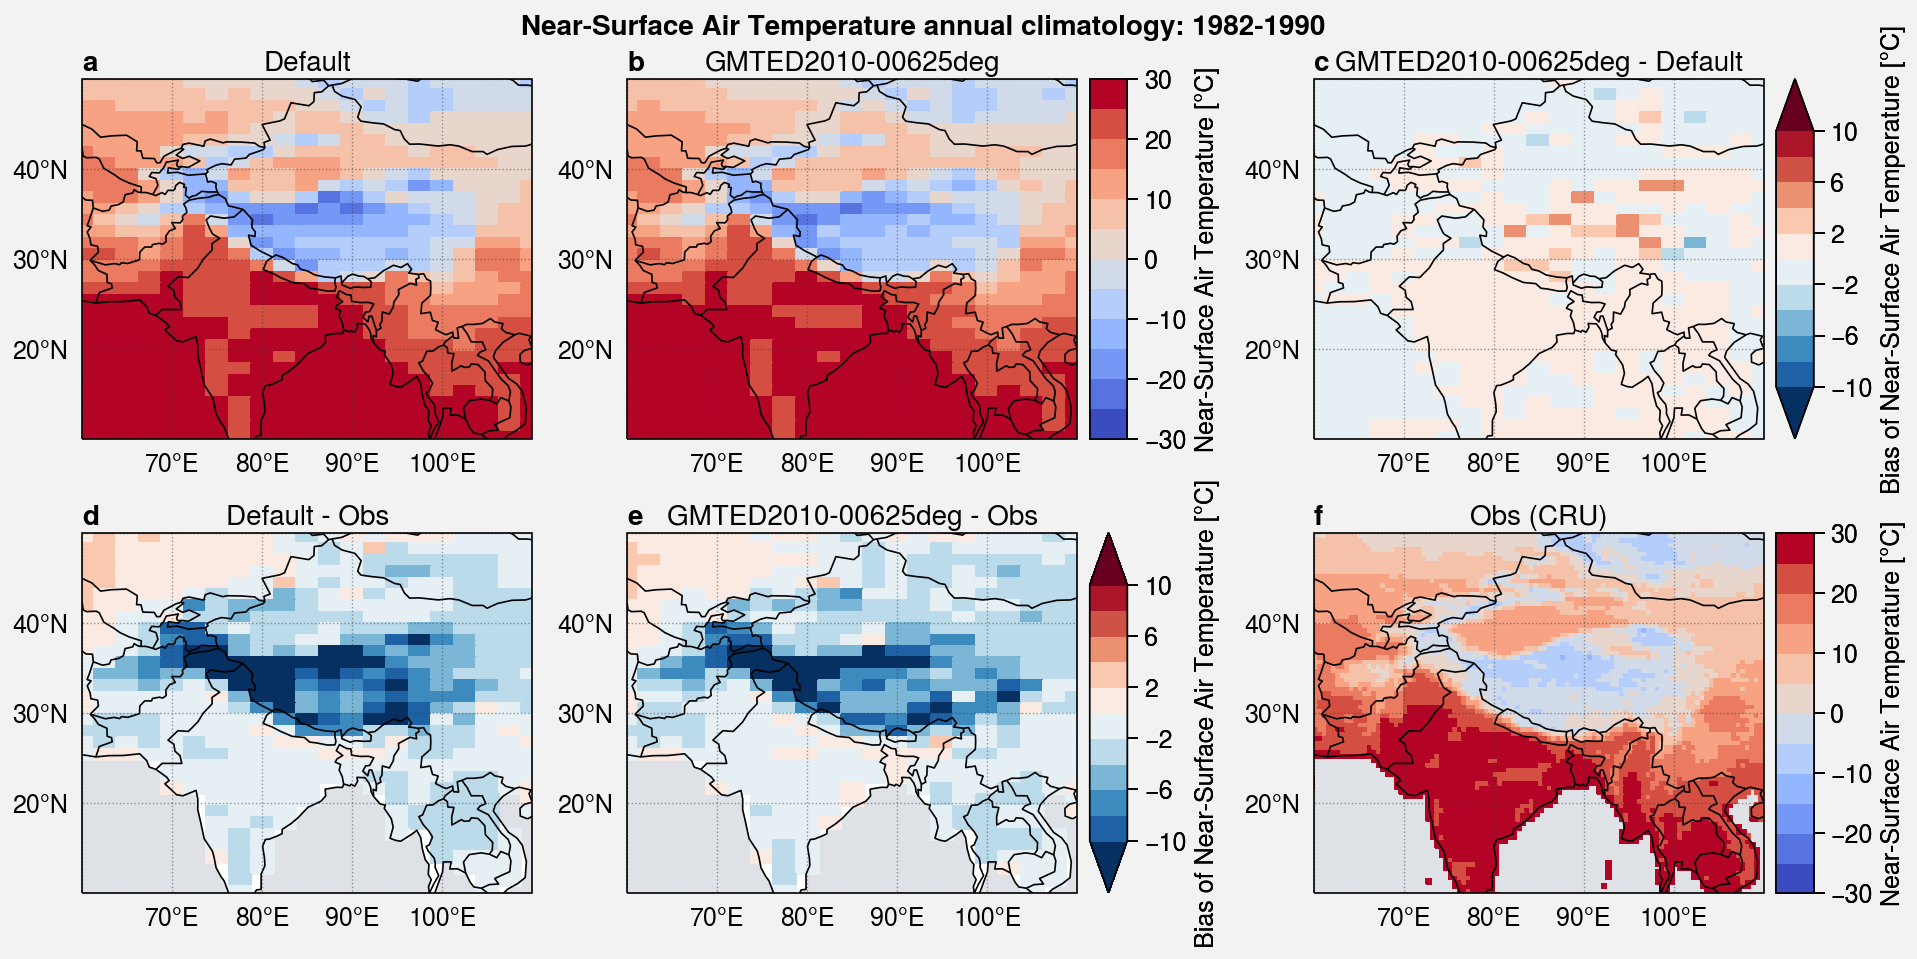

In [13]:
f, axs = plot.subplots(proj='cyl', ncols=3, nrows=2)

levels_diff = plot.arange(-10,10,2)
cmap_diff = 'BuRd'
extend_diff = 'both'

# First row: differences GMTED2010-00625deg / not guide
axs[0].pcolormesh(model_def_clim, cmap=cmap, levels=levels)
axs[0].format(title='Default')

m1 = axs[1].pcolormesh(model_GMTED2010_clim, cmap=cmap, levels=levels)
axs[1].format(title='GMTED2010-00625deg')
axs[1].colorbar(m1, label=label+ ' ['+units+']')

m2 = axs[2].pcolormesh(model_GMTED2010_clim - model_def_clim, cmap=cmap_diff, levels=levels_diff, extend=extend_diff)
axs[2].format(title='GMTED2010-00625deg - Default')
axs[2].colorbar(m2, label='Bias of '+label+ ' ['+units+']')


# Second row: differences with obs

axs[3].pcolormesh(model_def_clim - obs_clim_regrid, cmap=cmap_diff, levels=levels_diff, extend=extend_diff)
axs[3].format(title='Default - Obs')

axs[4].pcolormesh(model_GMTED2010_clim - obs_clim_regrid, cmap=cmap_diff, levels=levels_diff, extend=extend_diff)
axs[4].format(title='GMTED2010-00625deg - Obs')
axs[4].colorbar(m2, label='Bias of '+label+ ' ['+units+']')

axs[5].pcolormesh(obs_clim, cmap=cmap, levels=levels)
axs[5].format(title='Obs ('+obs_name+')')
axs[5].colorbar(m1, label=label+ ' ['+units+']')


axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle=label+" annual climatology: "+period.start+"-"+period.stop,
    lonlines=10, latlines=10, abc=True, latlim=latlim, lonlim=lonlim
)

f.save('img/'+var+'_relief_'+period.start+'-'+period.stop+'.jpg')
f.save('img/'+var+'_relief_'+period.start+'-'+period.stop+'.png')
f.save('img/'+var+'_relief_'+period.start+'-'+period.stop+'.pdf')